# Installations and Imports

In [1]:
!pip install mujoco mujoco_mjx brax playground

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.8/704.8 kB 24.4 MB/s eta 0:00:00


In [1]:
import jax
import mujoco
from mujoco import mjx
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

# Clone Repository

In [2]:
!git clone https://github.com/shaoanlu/control_system_project_template.git

Cloning into 'control_system_project_template'...
remote: Enumerating objects: 683, done.
remote: Counting objects: 100% (230/230), done.
remote: Compressing objects: 100% (171/171), done.
remote: Total 683 (delta 89), reused 183 (delta 54), pack-reused 453 (from 1)
Receiving objects: 100% (683/683), 7.58 MiB | 9.19 MiB/s, done.
Resolving deltas: 100% (309/309), done.


In [3]:
%cd control_system_project_template

/content/control_system_project_template


In [4]:
!pwd

/content/control_system_project_template


# Run simulation

In [5]:
from examples.mujoco_Go1.env_wrapper import Go1Env
from examples.mujoco_Go1.ppo import PPO, PPOParams, PPOParamsBuilder
from src.control.controller_factory import ControllerFactory

mujoco_menagerie not found. Downloading...


Cloning mujoco_menagerie: ██████████| 100/100 [00:26<00:00]


Successfully downloaded mujoco_menagerie


In [6]:
velocity_kick_range = [0.0, 0.0]  # Disable velocity kick.
kick_duration_range = [0.05, 0.2]


def sample_pert(rng, env, state):
    rng, key1, key2 = jax.random.split(rng, 3)
    pert_mag = jax.random.uniform(key1, minval=velocity_kick_range[0], maxval=velocity_kick_range[1])
    duration_seconds = jax.random.uniform(key2, minval=kick_duration_range[0], maxval=kick_duration_range[1])
    duration_steps = jax.numpy.round(duration_seconds / env.dt).astype(jax.numpy.int32)
    state.info["pert_mag"] = pert_mag
    state.info["pert_duration"] = duration_steps
    state.info["pert_duration_seconds"] = duration_seconds
    return rng

## Instantiate simulator and controller

In [7]:
# instantiate mujoco Env
env_name = "Go1JoystickFlatTerrain"  # Choose between Go1Handstand and Go1JoystickFlatTerrain
rng = jax.random.PRNGKey(0)
env = Go1Env(env_name=env_name)

# Instantiate controller based on env_name
factory = ControllerFactory()
factory.register_controller(PPOParams, PPO)
controller_config = {"npy_path": f"examples/mujoco_Go1/nn_params/{env_name}"}
ppo_params = PPOParamsBuilder().build(config=controller_config)
controller = factory.build(params=ppo_params)

## Run closed loop simunation

In [8]:
rollout = []
modify_scene_fns = []
swing_peak = []
linvel = []
angvel = []

command = jax.numpy.array([0, 0, 0.9])
state = env.reset(rng)
for i in tqdm(range(env.env_cfg.episode_length)):
    state.info["command"] = command
    try:
        if state.info["steps_since_last_pert"] < state.info["steps_until_next_pert"]:
            rng = sample_pert(rng, env, state)
    except:
        pass
    act_rng, rng = jax.random.split(rng)
    ctrl = controller.control(state.obs["state"])

    state = env.step(state, ctrl)
    rollout.append(state)
    swing_peak.append(state.info["swing_peak"])
    linvel.append(env.get_global_linvel(state.data))
    angvel.append(env.get_gyro(state.data))

100%|██████████| 1000/1000 [00:55<00:00, 18.04it/s]


# Visualize Simulation Result

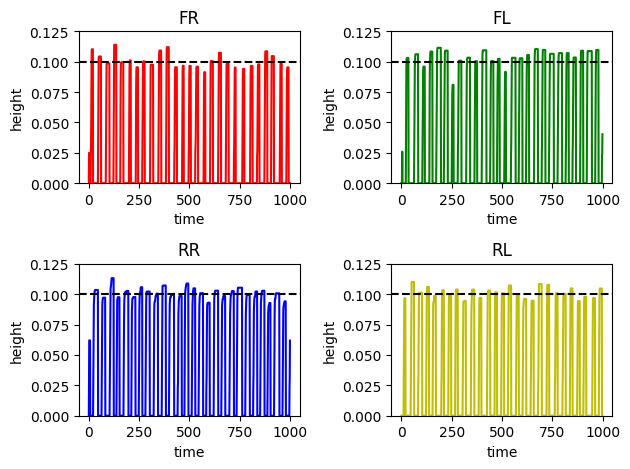

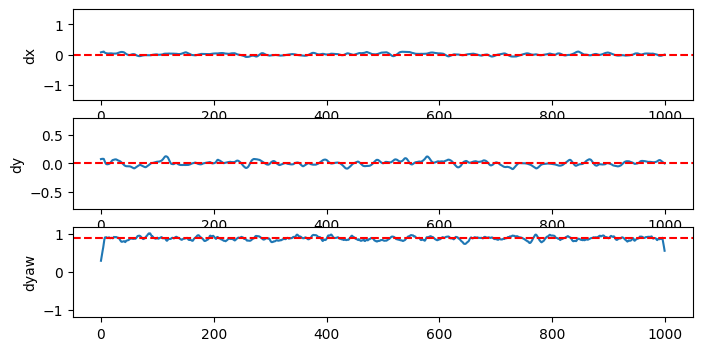

In [9]:
# visualization
# Plot each foot in a 2x2 grid.
swing_peak = jax.numpy.array(swing_peak)
names = ["FR", "FL", "RR", "RL"]
colors = ["r", "g", "b", "y"]
fig, axs = plt.subplots(2, 2)
for i, ax in enumerate(axs.flat):
    ax.plot(swing_peak[:, i], color=colors[i])
    ax.set_ylim([0, env.env_cfg.reward_config.max_foot_height * 1.25])
    ax.axhline(env.env_cfg.reward_config.max_foot_height, color="k", linestyle="--")
    ax.set_title(names[i])
    ax.set_xlabel("time")
    ax.set_ylabel("height")
plt.tight_layout()
plt.show()

linvel_x = jax.numpy.array(linvel)[:, 0]
linvel_y = jax.numpy.array(linvel)[:, 1]
angvel_yaw = jax.numpy.array(angvel)[:, 2]

# Plot whether velocity is within the command range.
linvel_x = jax.numpy.convolve(linvel_x, jax.numpy.ones(10) / 10, mode="same")
linvel_y = jax.numpy.convolve(linvel_y, jax.numpy.ones(10) / 10, mode="same")
angvel_yaw = jax.numpy.convolve(angvel_yaw, jax.numpy.ones(10) / 10, mode="same")

fig, axes = plt.subplots(3, 1, figsize=(8, 4))
axes[0].plot(linvel_x)
axes[1].plot(linvel_y)
axes[2].plot(angvel_yaw)

axes[0].set_ylim(-env.env_cfg.command_config.a[0], env.env_cfg.command_config.a[0])
axes[1].set_ylim(-env.env_cfg.command_config.a[1], env.env_cfg.command_config.a[1])
axes[2].set_ylim(-env.env_cfg.command_config.a[2], env.env_cfg.command_config.a[2])

for i, ax in enumerate(axes):
    ax.axhline(state.info["command"][i], color="red", linestyle="--")

labels = ["dx", "dy", "dyaw"]
for i, ax in enumerate(axes):
    ax.set_ylabel(labels[i])